In [2]:
# Experimental classifier that uses a CNN architecture and softmax activation in the last layer

import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import sklearn.metrics as skm
import os
from sklearn.model_selection import train_test_split

In [3]:
# Load the datasets

data_path = '/Users/ec270266/Documents/Phd/Euclid/dev/output/psf_dataset/'
test_dataset = np.load(data_path + 'test_Euclid_res_20000_TestStars_id_001GT_100_bins.npy', allow_pickle=True)[()]
train_dataset = np.load(data_path + 'train_Euclid_res_52000_TrainStars_id_001GT_100_bins.npy', allow_pickle=True)[()]

In [4]:
test_size=len(test_dataset['stars'])
train_size=len(train_dataset['stars'])

In [5]:
def calculate_success_rate(confusion_matrix):
    """ Metric that contemplates success as the true spectral class with a tolerance of one adjacent class
    """
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    """ Callback to display training information only at the end of the training of one network
    """
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]
        final_acc = self.model.history.history['categorical_accuracy'][-1]
        final_val_acc = self.model.history.history['val_categorical_accuracy'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)
        print("Final accuracy:", final_acc, "Final validation accuracy:", final_val_acc)

completion_callback = TrainingCompletionCallback()

initializer = tf.keras.initializers.GlorotNormal(seed = 25)

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

class CNN_model:
    """Wrapper class to train the network with a PCA dataset and a given architecture."""
    def __init__(self, train_dataset, test_dataset, architecture):
        """Receives the name of the dataset and the already created network and loads the needed variables."""
        #train_stars = np.expand_dims(train_dataset['noisy_stars'], axis = 3)
        #self.x_test = np.expand_dims(test_dataset['noisy_stars'], axis = 3)
        train_stars = np.expand_dims(train_dataset['noisy_stars'], axis = 3)
        
        
        # self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
        #     train_stars, train_dataset['SED_ids'],test_size = test_size, shuffle = False
        # )
        
        # Double split same dataset to generate: train, val, test
        x_train, self.x_test, y_train, self.y_test = train_test_split(
            train_stars, train_dataset['SED_ids'], test_size = int(train_size/2.6), shuffle = False
        )
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
            x_train, y_train, test_size = int(train_size/2.6/2.6), shuffle = False
        )

        # self.x_test = np.expand_dims(test_dataset['stars'], axis = 3)
        # self.y_test = test_dataset['SED_ids']
        
        self.y_train_cat = tf.keras.utils.to_categorical(self.y_train,num_classes = 13)
        self.y_val_cat = tf.keras.utils.to_categorical(self.y_val,num_classes = 13)
        self.y_test_cat = tf.keras.utils.to_categorical(self.y_test,num_classes = 13)
        
        self.learning = []
        self.model = architecture
        
    
    def train_model(self, learning_rate, training_epochs, patience_epochs):

        self.model.compile(
            loss = 'categorical_crossentropy',
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate),
            metrics = 'categorical_accuracy'
        )
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)

        learn = self.model.fit(self.x_train, self.y_train_cat, epochs= training_epochs, verbose = 0,
                                        callbacks = [completion_callback,early_stopping], validation_data=(self.x_val,self.y_val_cat), shuffle=True) 

        self.learning.append(learn)

    def predict_test(self, verbose = True):
        """Makes predictions on the test data."""
        y_test_pred = self.model.predict(self.x_test)
        class_predictions = np.argmax(y_test_pred, axis = 1)

        self.f1_test = skm.f1_score(self.y_test, class_predictions, average = None)
        self.f1_mean_test = np.mean(self.f1_test[:13])
        self.confusion_matrix_test = skm.confusion_matrix(self.y_test, class_predictions)
        self.success_rate_test = calculate_success_rate(self.confusion_matrix_test)

        if(verbose):
            print("Prediction results for the test set")
            print('Average F1 score:', self.f1_mean_test)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_test)
            print('\nSuccess rate:', self.success_rate_test)


    def predict_val(self, verbose = True):
        """Makes predictions on the validation data."""
        y_val_pred = self.model.predict(self.x_val)
        class_predictions = np.argmax(y_val_pred, axis = 1)

        self.f1_val = skm.f1_score(self.y_val, class_predictions, average = None)
        self.f1_mean_val = np.mean(self.f1_val[:13])
        self.confusion_matrix_val = skm.confusion_matrix(self.y_val, class_predictions)
        self.success_rate_val = calculate_success_rate(self.confusion_matrix_val)

        if(verbose):
            print("Prediction results for the validation set")
            print('Average F1 score:', self.f1_mean_val)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_val)
            print('\nSuccess rate:', self.success_rate_val)

    def save_model(self, N_model = 1):

        self.model.save(f"saved_models/{self.dataset_name}/my_model_{N_model}.h5")

    def load_model(self, N_model = 1):
        self.model = tf.keras.models.load_model(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")
        

    def plot_training_evolution(self):
        """Plot the loss function and accuracy evolution."""

        loss_evolution = self.learning[-1].history["loss"]
        val_loss_evolution = self.learning[-1].history["val_loss"]
        acc_evolution = self.learning[-1].history['categorical_accuracy']
        val_acc_evolution = self.learning[-1].history['val_categorical_accuracy']

        plt.figure(figsize = (9,5))
        plt.subplot(121)
        plt.plot(loss_evolution,label = "Train set")
        plt.plot(val_loss_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Loss function value")
        plt.legend()
        plt.title("Loss function evolution")

        plt.subplot(122)
        plt.plot(acc_evolution)
        plt.plot(acc_evolution,label = "Train set")
        plt.plot(val_acc_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Categorical accuracy evolution")

        print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])
        print("Training accuracy:", acc_evolution[-1], ", Validation accuracy:", val_acc_evolution[-1])

    def plot_cf_matrix(self):
        plt.figure(figsize= (12,10))
        heatmap = plt.imshow(self.confusion_matrix_test[:13,:], cmap='Blues')
        plt.xticks(np.arange(13), star_class_labels)
        plt.yticks(np.arange(13), star_class_labels)
        plt.colorbar(heatmap)
        plt.xlabel("Estimated spectral type")
        plt.ylabel("True spectral type")
        plt.show()

    def plot_metrics(self):
        plt.figure(figsize = (9,5))
        plt.bar(np.arange(13), height = self.f1_test[:13], tick_label = star_class_labels ,label = "F1 score")
        plt.axhline(self.f1_mean_test, color='red', linestyle='--', label = 'F1 score average')
        plt.axhline(self.success_rate_test, color='purple', label = 'Success rate')
        plt.xlabel("Spectral class")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

# LeNet5 Inspired Simple Network

In [6]:
architecture = tf.keras.Sequential([ 
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (32,32,1)),
    layers.MaxPooling2D((2,2)), #The original version has average pooling
    
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), #The original version has average pooling
    
    layers.Flatten(),
    layers.Dense(120, activation = 'relu'),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(13, activation = 'softmax'),
])
architecture.summary()

model3 = CNN_model(train_dataset, test_dataset, architecture)

Training completed. Number of epochs: 100 , Final training loss: 0.8273600935935974 , Final validation loss: 0.8415096402168274
Final accuracy: 0.6267483830451965 Final validation accuracy: 0.6296151876449585
241/241 [==============================] - 1s 2ms/step
Prediction results for the validation set
Average F1 score: 0.6197109689325213

Confusion matrix:
[[436 135  43   1   1   0   0   0   0   0   0   0   0]
 [272 181  88  16   3   0   0   0   0   0   0   0   0]
 [ 14  21 279 196  44   1   1   0   0   0   0   0   0]
 [  3   5 111 276 184  18   2   0   0   0   0   0   0]
 [  0   2   4  72 393 112  18   1   0   0   0   0   0]
 [  0   0   1   5  91 266 204  28   2   1   0   0   0]
 [  0   0   0   1   4  60 356 141   9   8   0   0   0]
 [  0   0   0   0   1   3  69 273 169  91   3   0   0]
 [  0   0   0   0   0   1  17 134 210 200   6   0   0]
 [  0   0   0   0   0   0   2  36 110 401  36   0   0]
 [  0   0   0   0   0   0   0   0   0  10 545  20   0]
 [  0   0   0   0   0   0   0   0

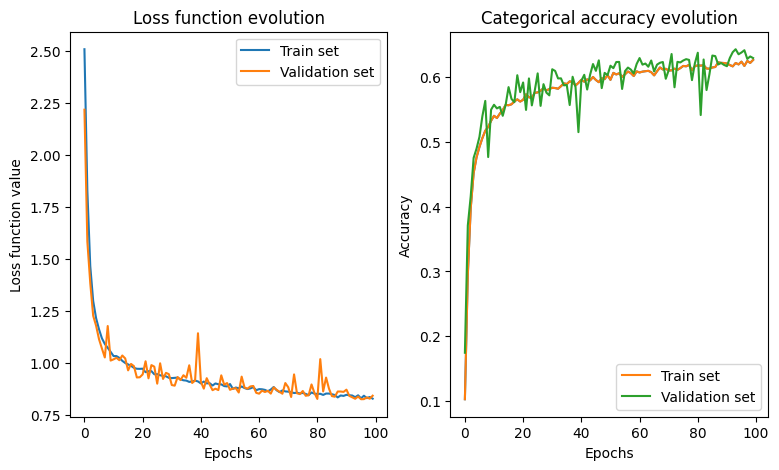

In [7]:
model3.train_model(training_epochs= 100, learning_rate= 0.001, patience_epochs= 100)
model3.predict_val()
model3.predict_test()
model3.plot_training_evolution()

# Original LeNet-5

In [9]:
architecture = tf.keras.Sequential([
    layers.Conv2D(6,(5,5), activation = 'tanh', input_shape = (32,32,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16,(5,5), activation = 'tanh'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(120,(5,5), activation = 'tanh'),

    layers.Flatten(),
    layers.Dense(84, activation='tanh'),
    layers.Dense(13, activation = 'softmax')
])
architecture.summary()

model4 = CNN_model(train_dataset, test_dataset, architecture)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten_2 (Flatten)         (None, 120)              

Training completed. Number of epochs: 100 , Final training loss: 0.7278878688812256 , Final validation loss: 0.8428348898887634
Final accuracy: 0.6624568104743958 Final validation accuracy: 0.6318252682685852
241/241 [==============================] - 0s 1ms/step
Prediction results for the validation set
Average F1 score: 0.6202461337973394

Confusion matrix:
[[520  75  19   1   0   1   0   0   0   0   0   0   0]
 [388 139  32   1   0   0   0   0   0   0   0   0   0]
 [ 30  85 331  93  13   4   0   0   0   0   0   0   0]
 [  5  39 230 206 108  10   0   1   0   0   0   0   0]
 [  1   3  28 115 372  81   1   1   0   0   0   0   0]
 [  0   1   2   8 115 399  60  11   2   0   0   0   0]
 [  0   0   0   1   8 227 288  43   7   4   1   0   0]
 [  0   0   0   0   0  22 129 265 148  43   2   0   0]
 [  0   0   0   0   0   9  45 162 265  86   1   0   0]
 [  0   0   0   0   0   1   6  58 183 328   9   0   0]
 [  0   0   0   0   0   0   0   0   1  32 525  17   0]
 [  0   0   0   0   0   0   0   0

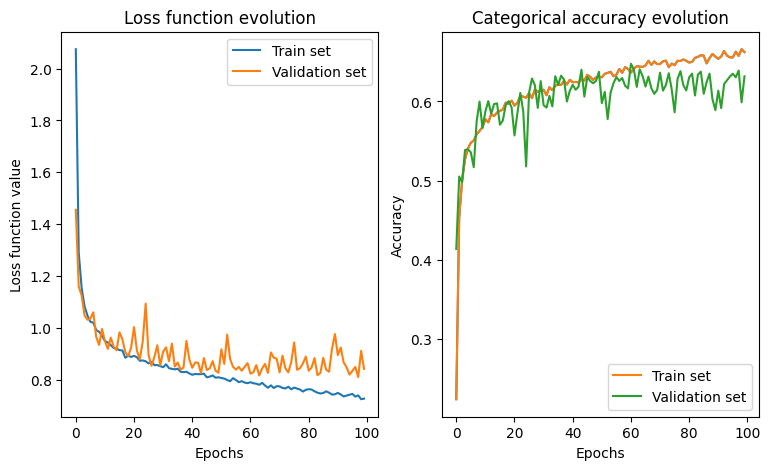

In [10]:
model4.train_model(training_epochs= 100, learning_rate= 0.001, patience_epochs= 50)
model4.predict_val()
model4.predict_test()
model4.plot_training_evolution()